# Time Series - Wind Power

In [1]:
import sys 
print(sys.version)

3.8.18 (default, Sep 11 2023, 13:39:12) [MSC v.1916 64 bit (AMD64)]


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm
from pmdarima.arima.utils import ndiffs

from pandas.plotting import autocorrelation_plot, lag_plot
from scipy import signal
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
from numpy import log

from dateutil.parser import parse 

import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'figure.figsize': (21,7), 'figure.dpi':120})
%matplotlib inline

##mis funciones
from clean_data import remover_valores_repetidos
from clean_data import rango_fechas_repe
from clean_data import rango_fechas_repe_exc
from clean_data import weighted_circular_mean



El dataset que se va a trabajar corresponde al Parque Eólico Achiras (localizado en Cordoba).

In [3]:
# Custom date parsing function for the "Date" column
def custom_date_parser(date_string):
    return pd.to_datetime(date_string, format='%d/%m/%Y %H:%M')

path = 'https://raw.githubusercontent.com/guilledesimone/MMA/main/Datos_ACHI_SOTR_2019_2023_horario.csv'


data_types = {          
    'TotPwrWTGs': float,        
    'Nro_Available_WTGs': float,
    'VelViento': float,
    'DirVientoPond': float,
    'Temp': float,
    'HumedadRel': float,
    'PresionAtm': float
    ,'ENERGIA_SMEC': float
    ,'ENERGIA_PRON_CAMMESA': float
    ,'ERROR_PRONOSTICO': float
}


# Read the CSV file with semicolon as delimiter, specifying the custom date parser
df = pd.read_csv(path, dtype=data_types,decimal=',', parse_dates=['FechaHora'], 
                 date_parser=custom_date_parser, delimiter=';', header=0)



#### Descripción del dataset
Este dataset corresponde a los datos producción de generación de energia y los meteorológicos del parque eólico Achiras ubicado en la provincia de Cordoba Argentina. El parque tiene una potencia instalada de 48 Mw.

El dataset cuenta con datos desde Enero del 2019 a la actualidad.  


#### Descripción de las variables del dataset
* TotPwrWTGs: Es la suma de la energia horaria generada por cada turbina del parque. Fuente sistema Scada del parque        
* Nro_Available_WTGs: Es un contador de turbinas que estan en un estado de indisponibilidad, se infiere este estado por estar consumiendo energia auxiliar (valores de potencia en 0 o negativos)
* VelViento: Velocidad promedio del viento horaria. Fuente Estación meteorologica del parque. 
* DirVientoPond: Dirección del viento horaria promedio ponderado con la velocidad del viento.   
* Temp: Temperatura ambiente promedio horario. Fuente Estación meteorologica del parque.
* HumedadRel: Humedad promedio horaria. Fuente Estación meteorologica del parque.
* PresionAtm: Presion atmosféria horaria. Fuente Estación meteorologica del parque.   
* ENERGIA_SMEC: Es la energia horaria neta producida medida por el medidor de energia del parque. Es por la que remunera Cammesa o el cliente. Es un poco menor que la TotPwrWTGs por que resta la energia auxiliar consumida por la propia planta para producir.   
* ENERGIA_PRON_CAMMESA: Es la energia pronosticada por Cammesa que se va a producir en la planta. 
* ERROR_PRONOSTICO: Es el error del pronostico, diferencia entre ENERGIA_SMEC y ENERGIA_PRON_CAMMESA

Estas últimas 3 variables provienen de la base de datos de Cammesa y la ENERGIA_SMEC esta garantizado que es un dato de calidad por que se interroga directamente desde el medidor de energia y se utiliza para facturar.

In [4]:
#cambio nombre de las columnas


nom_colum = ['FechaHora','EnergiaTGW','AerosDisp','VelViento','DirViento','TempAmb','HumedadRel','PresionAtm','EnergiaSMEC','PronosticoCammesa','ErrorPronostico']

df.columns = nom_colum

df.head(5)

,FechaHora,EnergiaTGW,AerosDisp,VelViento,DirViento,TempAmb,HumedadRel,PresionAtm,EnergiaSMEC,PronosticoCammesa,ErrorPronostico
0,2019-01-30 13:00:00,0.95,9.00,4.43,154.16,23.51,66.46,914.10,1.64,NaN,NaN
1,2019-01-30 14:00:00,1.56,12.67,4.11,128.52,23.96,65.92,914.17,1.42,NaN,NaN
2,2019-01-30 15:00:00,4.34,13.00,5.65,109.57,24.16,66.63,914.03,4.23,NaN,NaN
3,2019-01-30 16:00:00,10.54,13.33,6.49,89.30,24.49,64.94,913.62,10.33,NaN,NaN
4,2019-01-30 17:00:00,12.73,14.00,6.58,83.76,24.60,66.79,913.12,12.51,NaN,NaN


#### Limpieza de datos

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41087 entries, 0 to 41086
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   FechaHora          41087 non-null  datetime64[ns]
 1   EnergiaTGW         41008 non-null  float64       
 2   AerosDisp          41087 non-null  float64       
 3   VelViento          41010 non-null  float64       
 4   DirViento          41010 non-null  float64       
 5   TempAmb            41010 non-null  float64       
 6   HumedadRel         41010 non-null  float64       
 7   PresionAtm         41010 non-null  float64       
 8   EnergiaSMEC        41087 non-null  float64       
 9   PronosticoCammesa  29245 non-null  float64       
 10  ErrorPronostico    29245 non-null  float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 3.4 MB


#### Verficación de valores nulos

In [6]:
df.isnull().sum()

FechaHora                0
EnergiaTGW              79
AerosDisp                0
VelViento               77
DirViento               77
TempAmb                 77
HumedadRel              77
PresionAtm              77
EnergiaSMEC              0
PronosticoCammesa    11842
ErrorPronostico      11842
dtype: int64

El valor a predecir es el de EnergiaSMEC, como se puede observar para las variables meteorológicas hay 77 valores en null y ademas debo analizar la calidad de las variables meteorológicas para detectar inconsistencias. Esto implica que hubo un problema de comunicación con la estación meteorologica o con alguno de los sensores.  

#### Analisis de inconsistencias en variable meteorológicas

In [7]:
num_vars= nom_colum[1:9]
df[num_vars].describe().T

,count,mean,std,min,25%,50%,75%,max
EnergiaTGW,41008.0,23.316093,17.025567,-0.75,6.95,21.67,40.7125,48.84
AerosDisp,41087.0,13.109466,3.535180,0.00,13.17,14.50,15.0000,15.00
VelViento,41010.0,8.254799,4.588230,0.00,5.02,7.66,11.3000,29.66
DirViento,41010.0,184.640747,119.633434,0.00,73.26,158.39,330.9175,359.88
TempAmb,41010.0,15.234178,6.719892,-26.17,10.72,15.78,19.6000,33.45
HumedadRel,41010.0,51.016145,21.968663,0.00,33.69,52.26,70.5800,82.65
PresionAtm,41010.0,870.128270,186.830046,0.00,909.02,912.16,915.2300,927.72
EnergiaSMEC,41087.0,22.747475,16.651670,0.00,6.68,21.17,39.8400,47.75


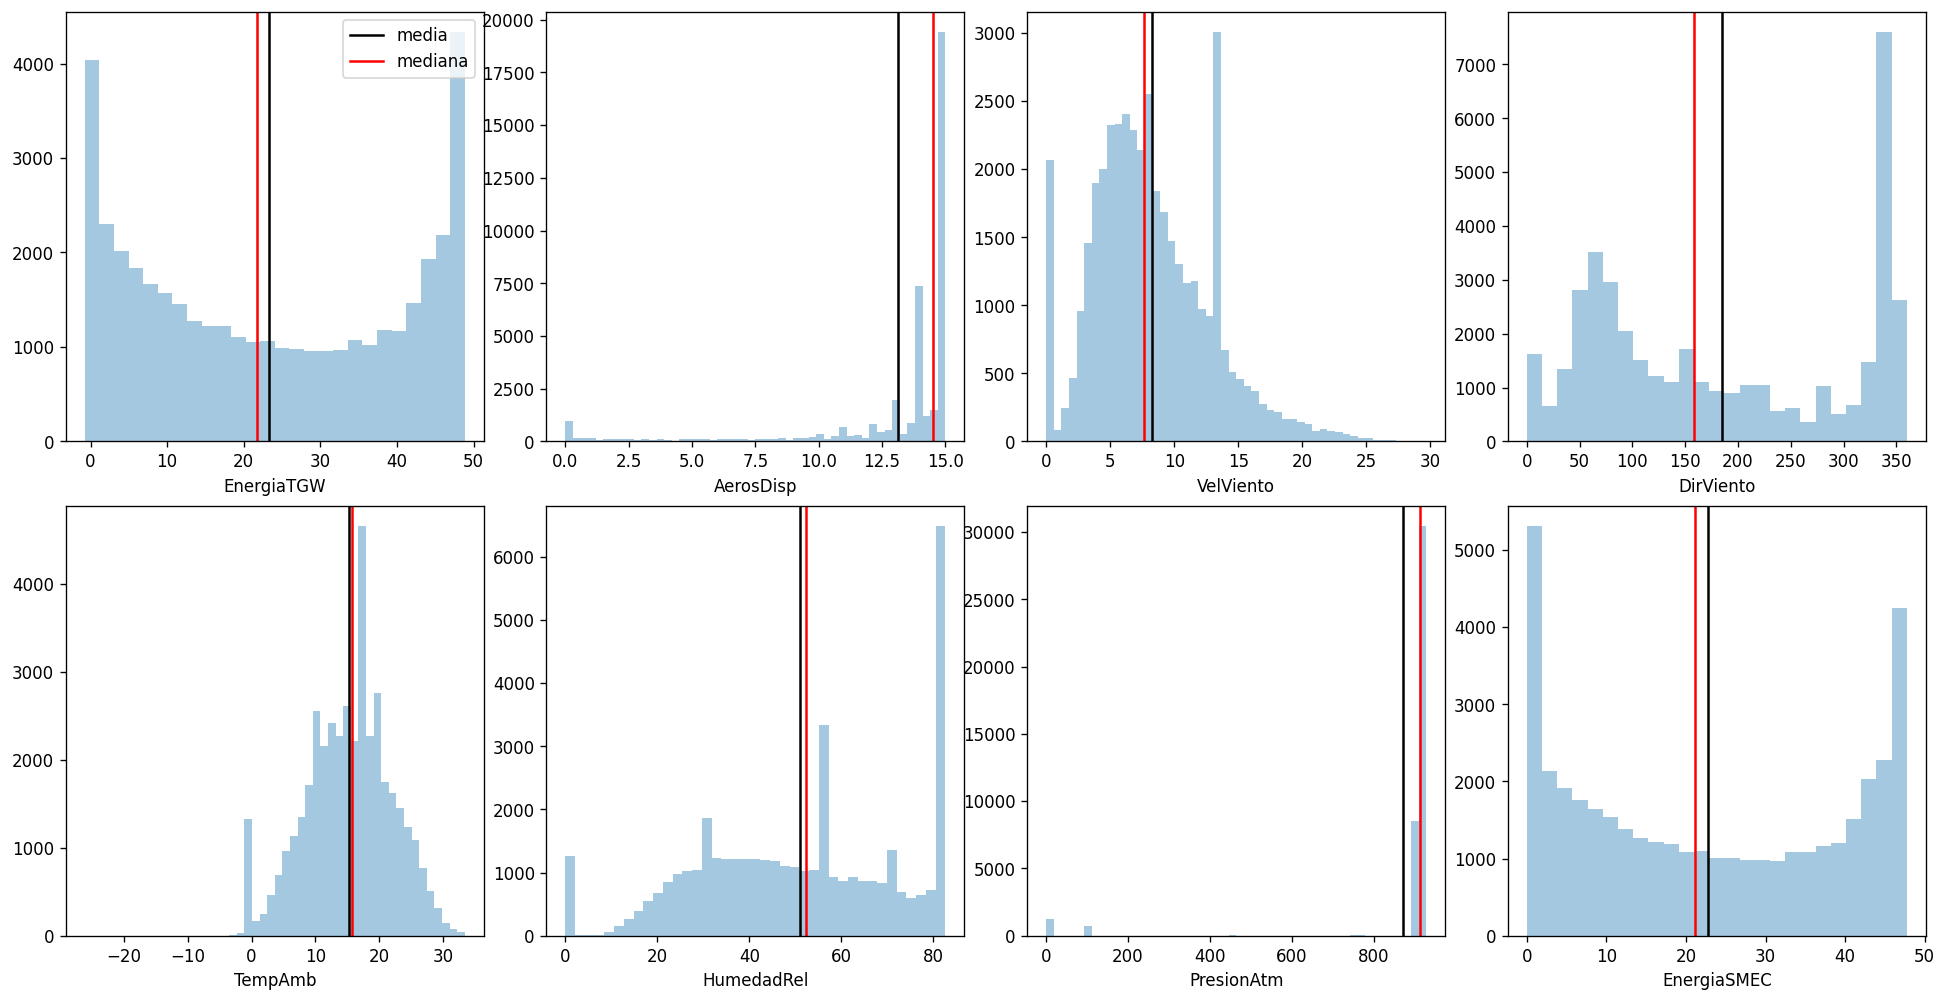

In [8]:
# Distribuciones para cada variable numerica
f,ax = plt.subplots(2,4,figsize=(20,10),gridspec_kw={'wspace':0.15,'hspace':0.15})

ax = ax.ravel()
for i,col in enumerate(num_vars):
    sns.distplot(df[col].astype(float),ax=ax[i],kde=False)
    ax[i].axvline(x=df[col].mean(),color='k',label='media')
    ax[i].axvline(x=df[col].median(),color='r',label='mediana')    
# Turn off the last subplot
if len(num_vars) < len(ax):
    ax[len(num_vars)].remove()
   
ax[0].legend();

In [9]:
df[num_vars].describe().T

,count,mean,std,min,25%,50%,75%,max
EnergiaTGW,41008.0,23.316093,17.025567,-0.75,6.95,21.67,40.7125,48.84
AerosDisp,41087.0,13.109466,3.535180,0.00,13.17,14.50,15.0000,15.00
VelViento,41010.0,8.254799,4.588230,0.00,5.02,7.66,11.3000,29.66
DirViento,41010.0,184.640747,119.633434,0.00,73.26,158.39,330.9175,359.88
TempAmb,41010.0,15.234178,6.719892,-26.17,10.72,15.78,19.6000,33.45
HumedadRel,41010.0,51.016145,21.968663,0.00,33.69,52.26,70.5800,82.65
PresionAtm,41010.0,870.128270,186.830046,0.00,909.02,912.16,915.2300,927.72
EnergiaSMEC,41087.0,22.747475,16.651670,0.00,6.68,21.17,39.8400,47.75


Como se puede observar hay valores inconsistentes por los picos y outliers en todas las variables meteorológicas

###### Calculo de los promedios de las variables meteorológicas en base a la EnergiaSMEC
Calculos los valores promedio de las variables meteotológicas para valores discretizados con saltos de 0,5 MW de la variable EnergiaSMEC

Para calcular los valores promedio de las variables meteorológicas elimino los nulos y los valores inconsistentes, que distorcionan el calculo de la media

In [10]:
#variables meteorológicas
meteo_vars=['VelViento','DirViento','TempAmb','HumedadRel','PresionAtm']

In [11]:
#Borro los registros que tiene valor nulo
df_aux=df.dropna(subset=['EnergiaTGW'])

In [12]:
#Verifico que no quedan nulos
df_aux.isnull().sum()

FechaHora                0
EnergiaTGW               0
AerosDisp                0
VelViento                0
DirViento                0
TempAmb                  0
HumedadRel               0
PresionAtm               0
EnergiaSMEC              0
PronosticoCammesa    11802
ErrorPronostico      11802
dtype: int64

In [13]:
#remuevo los registros que tiene valores repetidos para la VelViento durante 3 horas consecutivas
df_aux=remover_valores_repetidos(df_aux, 'FechaHora', 'VelViento', 3,'n')

Se removieron 6372 registros repetidos


In [14]:
#Elimino los registros de outliers de TempAmb
df_aux.drop(df_aux[(df_aux['TempAmb'] <= -5) | (df_aux['TempAmb'] >= 40)].index, inplace=True)

#Elimino los registros de outliers de PresionAtm
#df_aux.drop(df_aux[(df_aux['PresionAtm'] <= 800) | (df_aux['PresionAtm'] >= 1000)].index, inplace=True)

#Elimino los registros cuando todas las variables meteorologicas son 0
df_aux.drop(df_aux[(df_aux[meteo_vars] == 0).all(axis=1)].index, inplace=True)

#df_aux[(df_aux['HumedadRel'] <= 40) | (df_aux['HumedadRel'] >= 100)].count()


In [15]:
#Reviso minimos y maximos de las variables 
df_aux[num_vars].describe().T

,count,mean,std,min,25%,50%,75%,max
EnergiaTGW,34632.0,23.125732,16.926063,-0.74,6.9500,21.420,40.31,48.84
AerosDisp,34632.0,13.098492,3.497751,0.00,13.0000,14.330,15.00,15.00
VelViento,34632.0,8.386324,4.287391,0.04,5.2575,7.530,10.71,29.66
DirViento,34632.0,179.677554,115.679135,0.00,73.2500,150.695,320.46,359.88
TempAmb,34632.0,15.702436,6.460510,-3.69,11.0200,15.550,20.39,33.45
HumedadRel,34632.0,51.989887,20.827857,0.00,34.4800,50.490,71.13,82.65
PresionAtm,34632.0,910.714487,27.777278,36.08,909.3000,912.010,914.82,927.72
EnergiaSMEC,34632.0,22.592672,16.552628,0.00,6.7300,20.980,39.47,47.75


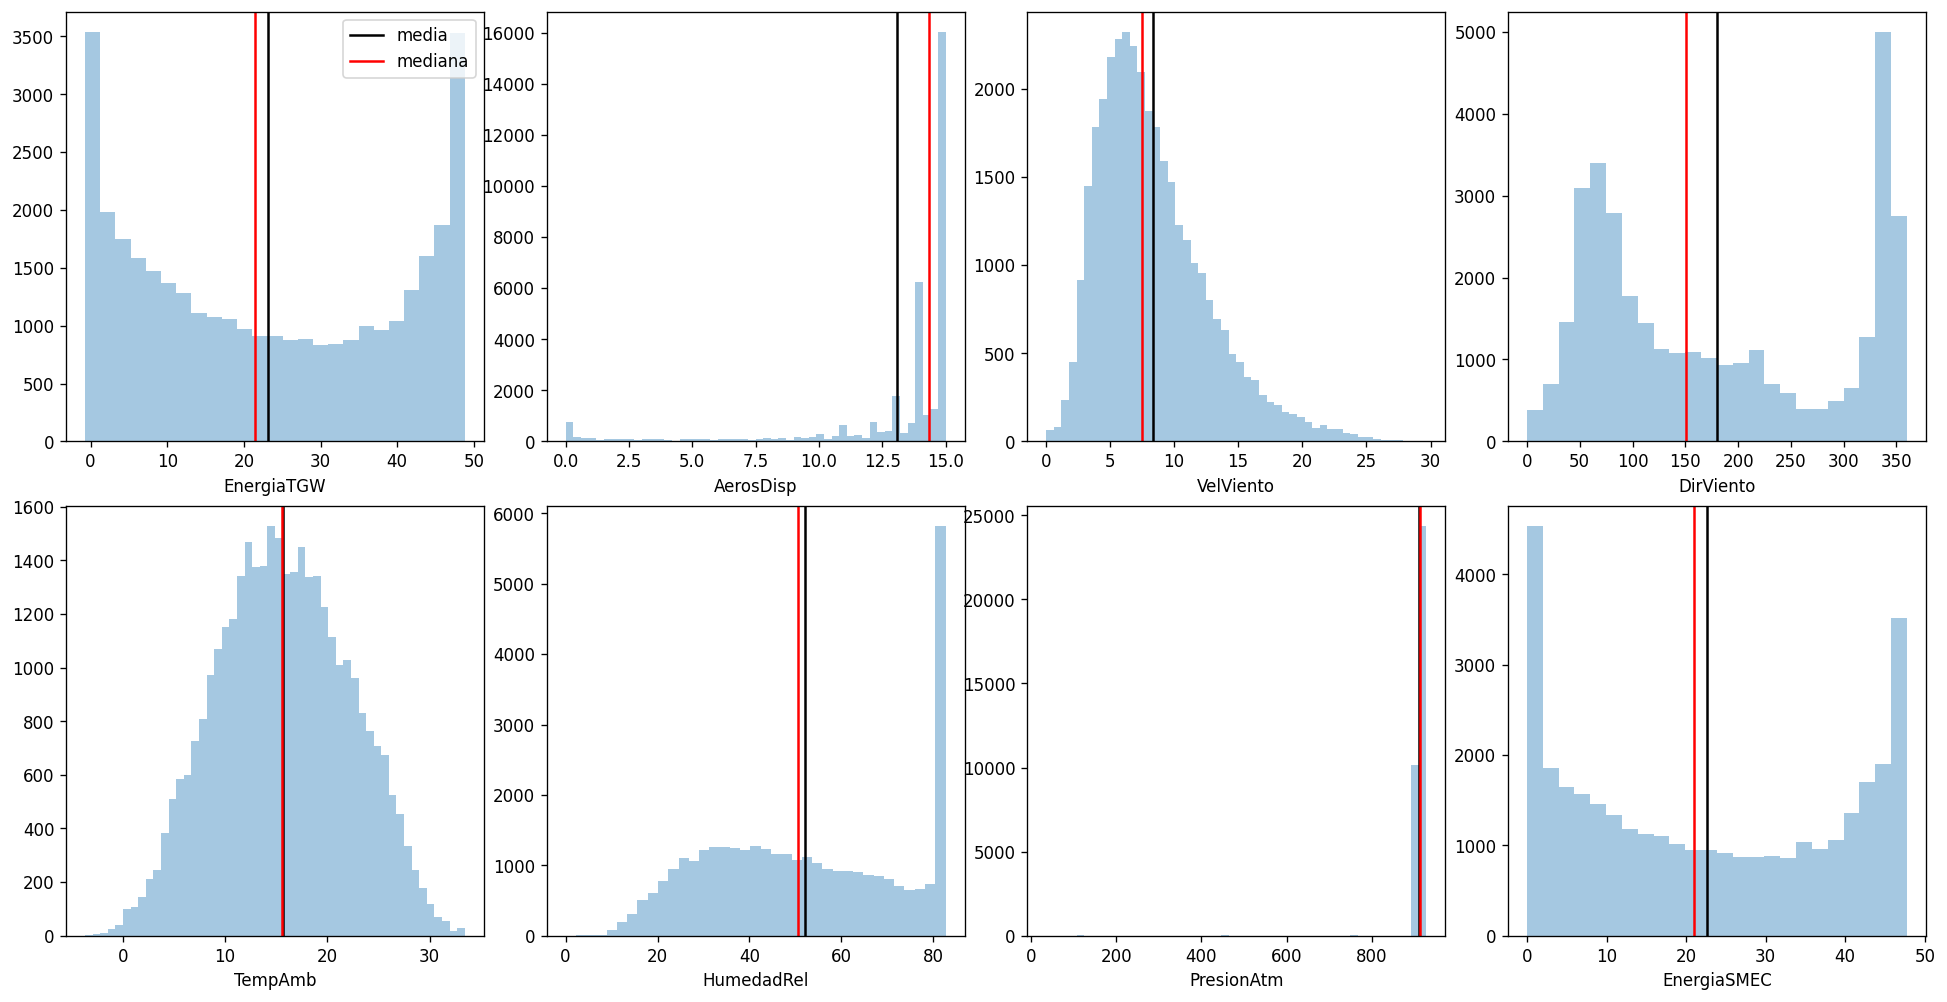

In [16]:
# Distribuciones para cada variable numerica
f,ax = plt.subplots(2,4,figsize=(20,10),gridspec_kw={'wspace':0.15,'hspace':0.15})

ax = ax.ravel()
for i,col in enumerate(num_vars):
    sns.distplot(df_aux[col].astype(float),ax=ax[i],kde=False)
    ax[i].axvline(x=df_aux[col].mean(),color='k',label='media')
    ax[i].axvline(x=df_aux[col].median(),color='r',label='mediana')    
# Turn off the last subplot
if len(num_vars) < len(ax):
    ax[len(num_vars)].remove()
   
ax[0].legend();

Luego de remover valores inconsistentes y outliers, no se observan en los histogramas outliers o picos que respondan a anomalias

##### Calculo de los promedios de las variables meteorológicas

In [17]:
# Discretizo la EnergiaSMEC con pasos de 0.5 MW
df['EnergiaSMEC_discreta'] = df['EnergiaSMEC'].apply(lambda x: round(x * 2) / 2)
df_aux['EnergiaSMEC_discreta'] = df_aux['EnergiaSMEC'].apply(lambda x: round(x * 2) / 2)

In [18]:
# Calculo la media de cada columna basado en los valores discretos de EnergiaProd
df_meteo = df_aux[['EnergiaSMEC_discreta','VelViento','DirViento','TempAmb', 'HumedadRel', 'PresionAtm']]

df_mean_meteo = df_meteo.groupby('EnergiaSMEC_discreta').mean().reset_index()

df_count_meteo = df_meteo.groupby('EnergiaSMEC_discreta').count().reset_index()



In [19]:
# Calcula el promedio circular ponderado por la VelViento agrupando por EnergySMEC
DirViento_grouped_means = df_meteo.groupby('EnergiaSMEC_discreta').apply(lambda x: weighted_circular_mean(x['DirViento'], x['VelViento']))

# Alinea la media calculada cob el index de df_mean_meteo
df_mean_meteo['DirViento'] = df_mean_meteo['EnergiaSMEC_discreta'].map(DirViento_grouped_means)


In [20]:
df_mean_meteo

,EnergiaSMEC_discreta,VelViento,DirViento,TempAmb,HumedadRel,PresionAtm
0,0.0,2.910119,149.611864,15.216228,51.118649,911.960242
1,0.5,3.615913,130.680526,15.210392,52.806495,912.995737
2,1.0,3.893406,139.322000,15.771578,52.024047,912.630781
3,1.5,4.252727,106.122432,15.334196,53.213339,912.837220
4,2.0,4.278483,121.386881,15.337949,53.828846,911.617350
...,...,...,...,...,...,...
92,46.0,12.952339,9.672812,16.379123,48.139805,909.512729
93,46.5,14.107234,14.267320,17.036682,50.005713,910.579921
94,47.0,14.554530,356.667040,14.201614,44.795552,902.913344
95,47.5,15.460930,357.275809,14.714377,44.702430,908.242035


In [21]:
#df_count_meteo

In [22]:
# Realizo la unión de los DataFrames en base a las columna 'EnergiaSMEC_discreta'
merged_df = df.merge(df_mean_meteo, 
                 on=['EnergiaSMEC_discreta'], 
                 how='left', suffixes = ('', '_mean'))

In [23]:
#Imputo la media en los registros nulos
mask = merged_df[meteo_vars].isnull().all(axis=1)

# Imputo en los registors nulos de las variables meteorologicas los valores medios
merged_df.loc[mask, 'VelViento'] = merged_df.loc[mask, 'VelViento_mean']
merged_df.loc[mask, 'DirViento'] = merged_df.loc[mask, 'DirViento_mean']
merged_df.loc[mask, 'TempAmb'] = merged_df.loc[mask, 'TempAmb_mean']
merged_df.loc[mask, 'HumedadRel'] = merged_df.loc[mask, 'HumedadRel_mean']
merged_df.loc[mask, 'PresionAtm'] = merged_df.loc[mask, 'PresionAtm_mean']

# Imputo en los registors nulos de EnergiaTGW el valor medio 
merged_df['EnergiaTGW'].fillna(merged_df['EnergiaTGW'].mean(), inplace=True)


In [24]:
#verifico si quedo algun valor nulo
merged_df.isnull().sum()

FechaHora                   0
EnergiaTGW                  0
AerosDisp                   0
VelViento                   0
DirViento                   0
TempAmb                     0
HumedadRel                  0
PresionAtm                  0
EnergiaSMEC                 0
PronosticoCammesa       11842
ErrorPronostico         11842
EnergiaSMEC_discreta        0
VelViento_mean              0
DirViento_mean              0
TempAmb_mean                0
HumedadRel_mean             0
PresionAtm_mean             0
dtype: int64

In [25]:
# Utilizo la funcion rango_fechas_repe devuelve un data_range con los periodos de fecha 
# con valores repetidos en VelViento

dr=rango_fechas_repe(df, 'FechaHora', 'VelViento', 3,'y')

Valor 6.75 repetido 3 veces en las fechas: 2019-02-09 05:00:00 - 2019-02-09 07:00:00
Existen 6372 registros repetidos
Valor 7.21 repetido 4 veces en las fechas: 2019-02-12 04:00:00 - 2019-02-12 07:00:00
Existen 6372 registros repetidos
Valor 9.72 repetido 3 veces en las fechas: 2019-02-23 05:00:00 - 2019-02-23 07:00:00
Existen 6372 registros repetidos
Valor 5.05 repetido 10 veces en las fechas: 2019-02-23 22:00:00 - 2019-02-24 07:00:00
Existen 6372 registros repetidos
Valor 6.83 repetido 12 veces en las fechas: 2019-03-08 21:00:00 - 2019-03-09 08:00:00
Existen 6372 registros repetidos
Valor 5.8 repetido 3 veces en las fechas: 2019-03-10 06:00:00 - 2019-03-10 08:00:00
Existen 6372 registros repetidos
Valor 3.16 repetido 3 veces en las fechas: 2019-03-11 06:00:00 - 2019-03-11 08:00:00
Existen 6372 registros repetidos
Valor 7.93 repetido 4 veces en las fechas: 2019-03-15 07:00:00 - 2019-03-15 10:00:00
Existen 6372 registros repetidos
Valor 4.87 repetido 3 veces en las fechas: 2019-03-17 0

In [26]:
#Imputo el valor medio de las variables meteorologicas para los rangos de fechas donde 
#hay valores repetidos
for prev_value, rep_count, start, end in dr:
        # Filtro por el rango de fechas
        mask = (merged_df['FechaHora'] >= start) & (merged_df['FechaHora'] <= end)

        # Actualizo los valores medios
        merged_df.loc[mask, 'VelViento'] = merged_df.loc[mask, 'VelViento_mean']
        merged_df.loc[mask, 'DirViento'] = merged_df.loc[mask, 'DirViento_mean']
        merged_df.loc[mask, 'TempAmb'] = merged_df.loc[mask, 'TempAmb_mean']
        merged_df.loc[mask, 'HumedadRel'] = merged_df.loc[mask, 'HumedadRel_mean']
        merged_df.loc[mask, 'PresionAtm'] = merged_df.loc[mask, 'PresionAtm_mean']


In [27]:
#Imputo la media en los registros de outliers de TempAmb
mask = (merged_df['TempAmb'] <= -5) | (merged_df['TempAmb'] >= 40)

merged_df.loc[mask, 'TempAmb'] = merged_df.loc[mask, 'TempAmb_mean']

#Imputo media en los registros de outliers de PresionAtm
mask = (merged_df['PresionAtm'] <= 800) | (merged_df['PresionAtm'] >= 1000)

merged_df.loc[mask, 'PresionAtm'] = merged_df.loc[mask, 'PresionAtm_mean']

#Imputo media en los registros que todas las variables meteorologicas son 0
mask = (merged_df[meteo_vars] == 0).all(axis=1)

# Actualizo los valores medios para todas las variables meteorologicas
merged_df.loc[mask, 'VelViento'] = merged_df.loc[mask, 'VelViento_mean']
merged_df.loc[mask, 'DirViento'] = merged_df.loc[mask, 'DirViento_mean']
merged_df.loc[mask, 'TempAmb'] = merged_df.loc[mask, 'TempAmb_mean']
merged_df.loc[mask, 'HumedadRel'] = merged_df.loc[mask, 'HumedadRel_mean']
merged_df.loc[mask, 'PresionAtm'] = merged_df.loc[mask, 'PresionAtm_mean']


In [28]:
df_clean=merged_df.iloc[:,0:11]

In [29]:
df_clean.shape

(41087, 11)

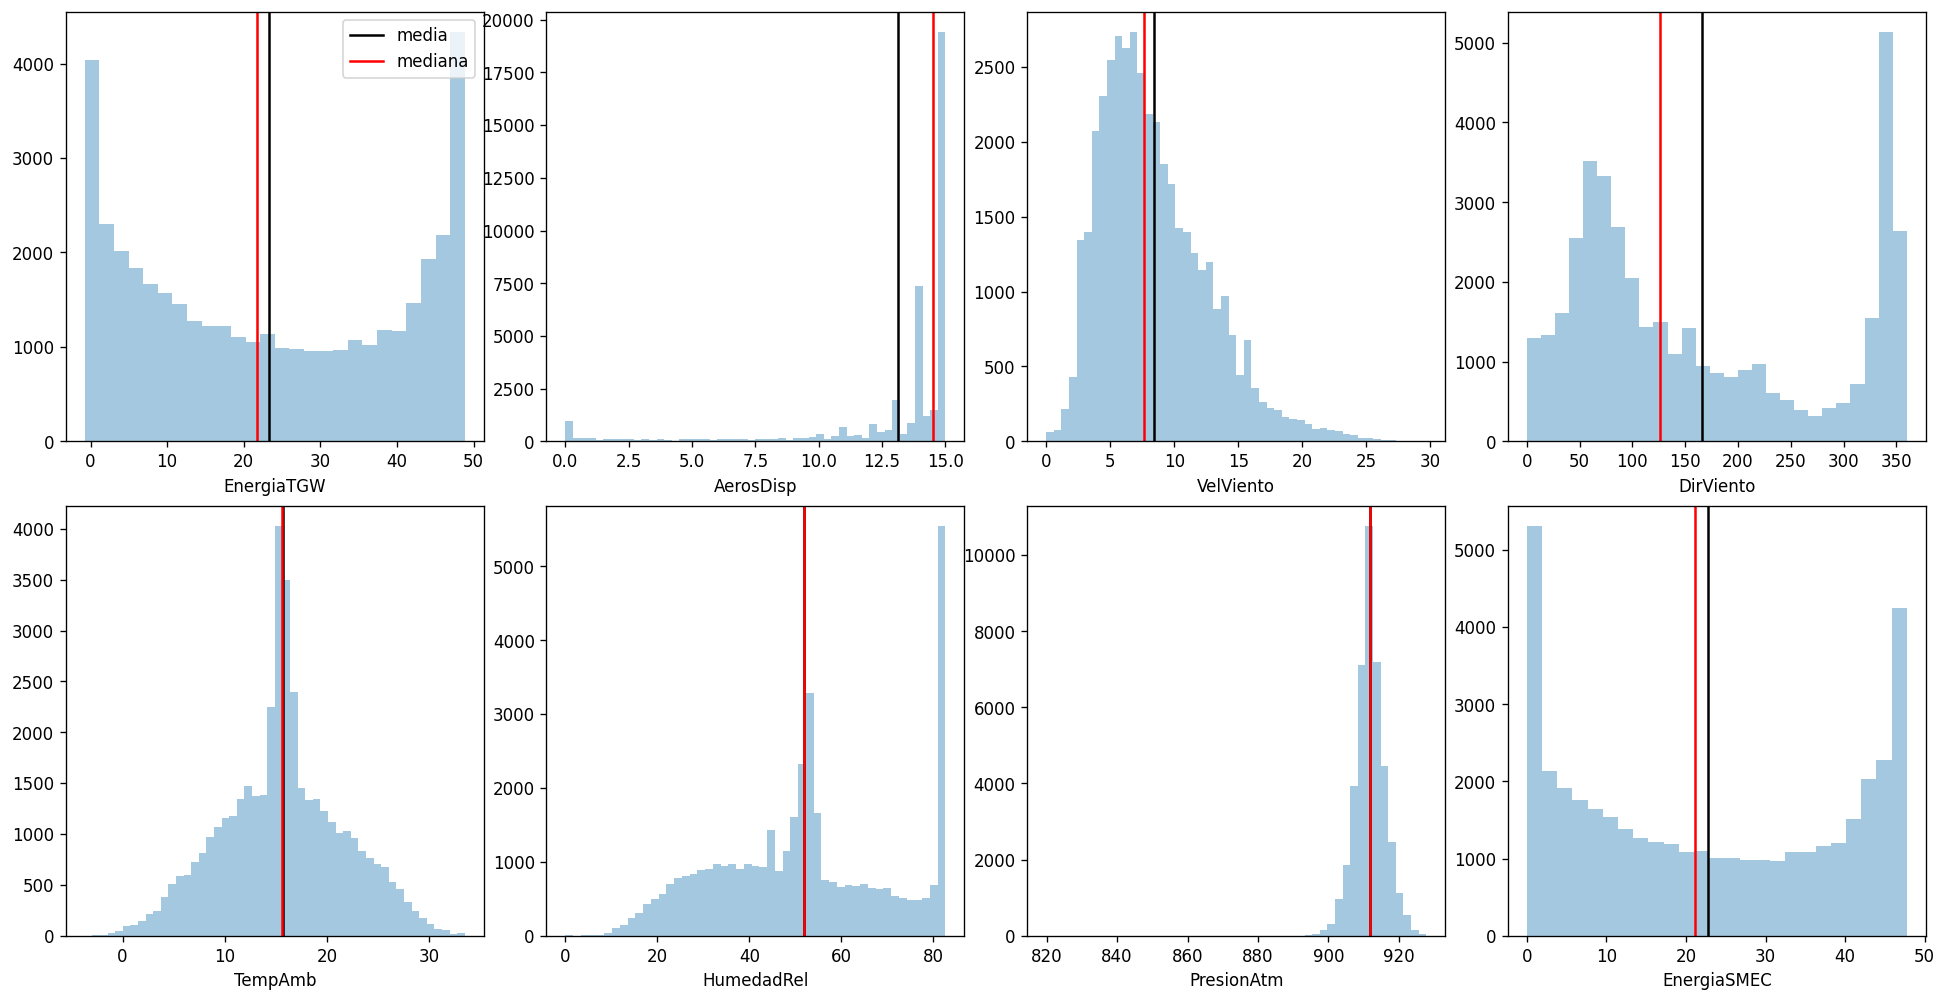

In [30]:
# Distribuciones para cada variable numerica
f,ax = plt.subplots(2,4,figsize=(20,10),gridspec_kw={'wspace':0.15,'hspace':0.15})

ax = ax.ravel()
for i,col in enumerate(num_vars):
    sns.distplot(df_clean[col].astype(float),ax=ax[i],kde=False)
    ax[i].axvline(x=df_clean[col].mean(),color='k',label='media')
    ax[i].axvline(x=df_clean[col].median(),color='r',label='mediana')    
# Turn off the last subplot
if len(num_vars) < len(ax):
    ax[len(num_vars)].remove()
   
ax[0].legend();

Como se puede observar en los histogramas el dataframe df_clean al reemplazar los valores inconsistentes de las variables metereológicas e imputarle la media en algunos casos se generan picos en las medias

<Axes: >

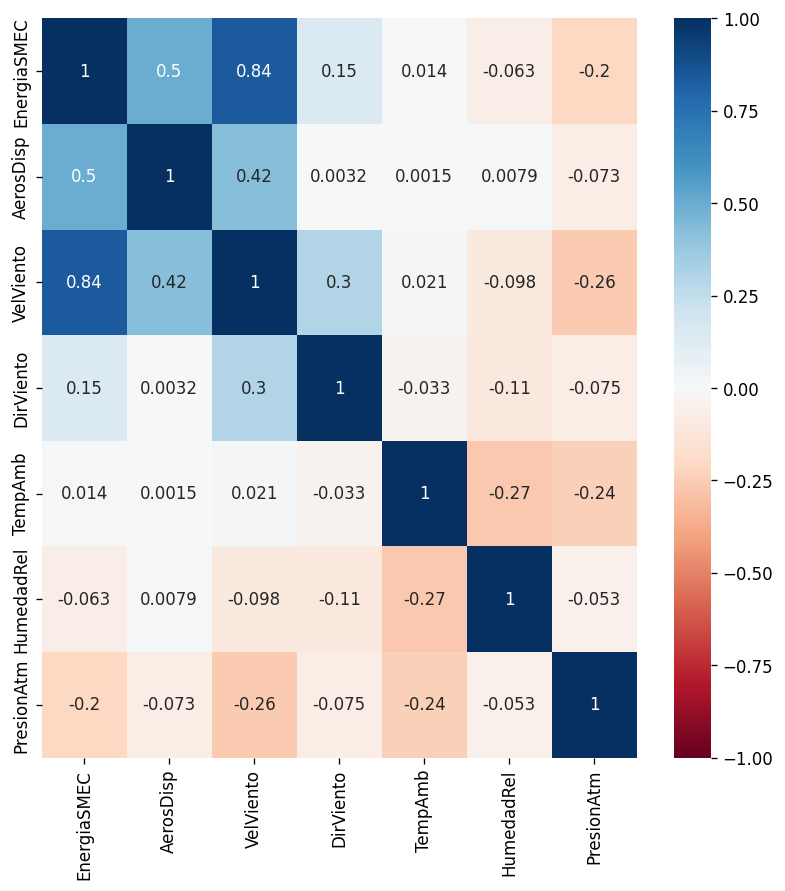

In [31]:
#Matriz de Correlacion
key_vars = ['EnergiaSMEC','AerosDisp','VelViento','DirViento','TempAmb','HumedadRel','PresionAtm']

plt.figure(figsize=(8,8))
sns.heatmap(df_clean[key_vars].corr(),annot=True,cmap='RdBu',vmin=-1)

En la matriz de correlacion se observa claramente la fuerte correlacion entre la Genracion y la velocidad del viento y los Aerogeneradores disponibles, en menor medida la direccion y aun menor la temperatura. Lo cual es totalmente razonable la correlacion con las variables de viento y disponibilidad de maquina, en el caso de la temperatura ambiente la correlacion esta asociada a lo que se conoce en la practica como derrating de temperatura perdida de eficiencia a medida que aumenta la temperatura 

In [32]:
#f,ax = plt.subplots(1,4,figsize=(20,6))
#ax = ax.ravel()
#for i,col in enumerate(['VelViento','AerosDisp','DirViento','TempAmb']):
#    sns.regplot(x='EnergiaSMEC',y=col,data=df_clean, ax=ax[i], lowess=True);

Pair plot tomando para valores repetidos la VelViento

![Pairplot](https://raw.githubusercontent.com/guilledesimone/MMA/main/PairPlotEnergiaSMEC2.png "PairPlot EnergiaSMEC")

Se siguen observando Outliers:
* Para EnergiaSMEC <> 0 la VelViento no puede ser 0
* Para EnergiaSMEC <> 0 no puede haber 0 AerosDisp

##### Deberia corregir estos valores imputandole la media?

In [33]:
#df_clean.to_csv('df_clean.csv', decimal=',', index=False)

In [35]:
from datetime import datetime

# Sample dates
date_format = "%Y-%m-%d %H:%M:%S"  # Format for the dates
start_date = datetime.strptime("2019-01-30 13:00:00", date_format)  # Replace with your start date
end_date = datetime.strptime("2023-12-06 00:00:00", date_format)  # Replace with your end date

# Calculate the difference in hours
difference = (end_date - start_date).total_seconds() / 3600  # Convert the difference to hours

print(f"The difference between the dates is {difference:.2f} hours.")


The difference between the dates is 42491.00 hours.


## Hasta aca el EDA, Limpieza y Correcciones

In [36]:
df = df_clean

### Visualización de la Series de Tiempo

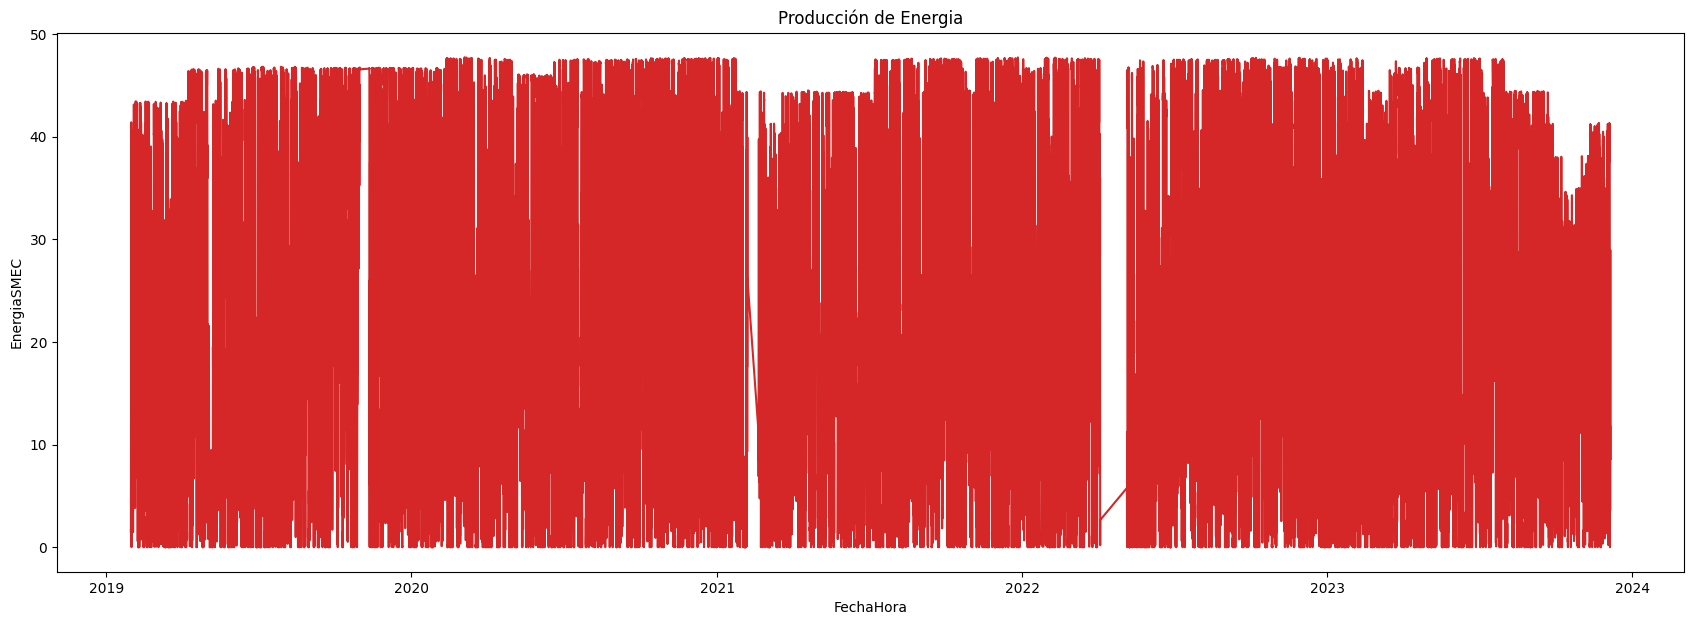

In [37]:
def plot_df(df, x, y, title="", xlabel='FechaHora', ylabel='EnergiaSMEC', dpi=100):
    plt.figure(figsize=(21,7), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
plot_df(df, x=df.FechaHora, y=df["EnergiaSMEC"], title='Producción de Energia')    

  
### Patrones estacionales
Como es una serie mensual y sigue un cierto patrón repetitivo cada año, se puede plotear cada uno de los mismos como una línea separada en un gráfico.

In [ ]:
# Preparacion de los datos.
df.reset_index(inplace=True)
df['year'] = [d.year for d in df.FechaHora]
df['month'] = [d.strftime('%b') for d in df.FechaHora]
years = df['year'].unique()


In [ ]:
df.head()

In [ ]:
# Preparacion de los colores.
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

In [ ]:
# Ploteo de las graficas.
plt.figure(figsize=(21,7), dpi=120)
for i, y in enumerate(years):
    if i > 0: 
         plt.plot('month', 'EnergiaSMEC', data=df.loc[df.year==y, :], color=mycolors[i], label=y)         
            #plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'EnergiaSMEC'][-1:].values[0], y, fontsize=12, color=mycolors[i]) 

            
            
# Ajustes finales a las graficas.
plt.gca().set(xlim=(-0.3, 11), ylim=(2, 30), ylabel='$Energy$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Energia Eolica Generada", fontsize=20)
plt.show()

Se observa que hay una caída en las ventas cada febrero y vuelve a subir en marzo, cayendo nuevamente en abril. Este patrón se repite cada año.  
Pero además, podemos observar que las ventas incrementan su volumen. Se puede visualizar esta tendencia y como varia cada año con boxplots, comparando mes a mes y año a año.

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(21,7), dpi=120)
#sns.boxplot(x='year', y='Exported_Energy_1H_kWh', data=df, ax=axes[0])
#sns.boxplot(x='month', y='Exported_Energy_1H_kWh', data=df.loc[~df.year.isin([2022, 2023]), :])
sns.boxplot(x='month', y='Exported_Energy_1H_kWh', data=df)

#axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes.set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

Aqui podemos ver que los meses de enero y diciembre son en los que mayor ventas hay.
### Tendencia
Si tenemos una serie de tiempo con valores positivos crecientes y queremos visualizar su crecimiento podemos plotearla de forma simétrica con el eje X con el signo cambiado para aprovechar su área como recurso de visualización.

In [ ]:
# Dataset de pasajeros de aerolineas.
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/AirPassengers.csv', parse_dates=['date'])
x = df['date'].values
y1 = df['value'].values

fig, ax = plt.subplots(1, 1, figsize=(21,7), dpi=120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(-800, 800)
plt.title('Air Passengers (Two Side View)', fontsize=16)
plt.hlines(y=0, xmin=np.min(df.date), xmax=np.max(df.date), linewidth=.5)
plt.show()

Volvemos a la presentación
## Análisis de series de tiempo
### Patrones en series de tiempo

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(21,7), dpi=120)
pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/guinearice.csv', parse_dates=['date'], index_col='date').plot(title='Trend Only', legend=False, ax=axes[0])

pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/sunspotarea.csv', parse_dates=['date'], index_col='date').plot(title='Seasonality Only', legend=False, ax=axes[1])

pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/AirPassengers.csv', parse_dates=['date'], index_col='date').plot(title='Trend and Seasonality', legend=False, ax=axes[2])

plt.show()

Otro aspecto a considerar es el comportamiento cíclico, sucede cuando el patrón de subida y bajada no ocurre en un intervalo fijo basado en fechas del calendario.  
### Series aditivas y multiplicativas
Descomponiendo la serie temporal Drug Sales en sus componentes mediante el paquete `statsmodels`

In [ ]:
# Volvemos a cargar el dataset A10.
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Decomposicion aditiva.
result_add = seasonal_decompose(df['value'], model='additive', extrapolate_trend='freq')

# Descomposicion multiplicativa.
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')

# Graficamos.
plt.rcParams.update({'figure.figsize': (21,14)})
result_add.plot().suptitle('Additive Decompose', fontsize=20)
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=20)
plt.show();

El parametro `extrapolate_trend='freq'` se encarga de los valores faltantes en la tendencia y los residuos al inicio de la serie.  
Si se observa atentamente los residuos de la descomposición aditiva, se puede observar un cierto patron restante no capturado por las otras componentes.  
La descomposición multiplicativa luce bastante aleatoria, lo cual es lo deseado en este tipo de descomposiciones.    
La salida numérica de tendencia, estacionalidad y componentes residuales son guardados en los objetos `result_mul` y `result_add` 

In [ ]:
# Extrayendo las componentes y guardandolas en un DataFrame: Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

El producto de `seas`, `trend` y `resid` deberia ser igual a `actual_values`  
Volvemos a la presentación.
### Series de tiempo estacionarias

In [ ]:
# Volvemos a cargar el dataset A10
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])

# ADF Test
result = adfuller(df.value.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(df.value.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

### Ruido blanco
Al igual que una serie estacionaria, el ruido blanco no es una función del tiempo, es decir su media y varianza no cambian con el tiempo. Pero la diferencia es que el ruido blanco es completamente aleatorio con media de cero. En el ruido blanco no hay un patron subyacente.  

In [ ]:
# Generando ruido aleatorio.
randvals = np.random.randn(1000)
pd.Series(randvals).plot(title='Random White Noise', color='k', figsize=(21,7));

Volvemos a la presentación.
### Quitar la tendencia
Restando la linea de mejor ajuste

In [ ]:
# Dataset de Drug Sales.
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])
# Funcion `signal()` del paquete sciPy
detrended = signal.detrend(df.value.values)
plt.figure(figsize=(21,7), dpi=120)
plt.plot(detrended)
plt.title('Drug Sales detrended by subtracting the least squares fit', fontsize=16);

Usando `statmodels`  y substrayendo el componente `trend`

In [ ]:
# Dataset de Drug Sales.
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Descomposicion multiplicativa.
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')

# Se la restamos al nivel de base.
detrended = df.value.values - result_mul.trend
plt.figure(figsize=(21,7), dpi=120)
plt.plot(detrended)
plt.title('Drug Sales detrended by subtracting the trend component', fontsize=16);

Volvemos a la presentación.
### Quitar la estacionalidad

In [ ]:
# Dataset de Drug Sales.
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Descomposicion multiplicativa.
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')

# Dividimos por la componente estacional.
deseasonalized = df.value.values / result_mul.seasonal

# Graficamos.
plt.figure(figsize=(21,7), dpi=120)
plt.plot(deseasonalized)
plt.title('Drug Sales Deseasonalized', fontsize=16);

Volvemos a la presentación
### Testear si una serie tiene estacionalidad

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv')
plt.rcParams.update({'figure.figsize':(21,7), 'figure.dpi':120})
# Graficamos la funcion de autocorrelacion para la serie de Drug Sales.
autocorrelation_plot(df.value.tolist());

En la serie mensual de Drug Sales hay patrones repetidos cada año con picos en las lineas 12, 24, 36, etc. De todas formas estos patrones no siempre son tan evidentes en datasets de la vida real.  
El Canova-Hansen Test es un test formal para determinar si es necesario quitar la estacionalidad de la serie mediante diferencia estacionaria.  
Volvemos a la presentación
### Valores faltantes
Introduzcamos valores faltantes en una serie conocida para medir la efectividad de cada una de ellas, luego mediremos el error cuadratico medio de los valores imputados contra los valores reales.

In [ ]:
# Importamos el dataset original y el que contiene datos faltantes.
df_orig = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date').head(100)
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10_missings.csv', parse_dates=['date'], index_col='date')

fig, axes = plt.subplots(7, 1, sharex=True, figsize=(20, 15))
plt.rcParams.update({'xtick.bottom' : False})

## 1. Actual -------------------------------
df_orig.plot(title='Actual', ax=axes[0], label='Actual', color='red', style=".-")
df.plot(title='Actual', ax=axes[0], label='Actual', color='green', style=".-")
axes[0].legend(["Missing Data", "Available Data"])

## 2. Forward Fill --------------------------
df_ffill = df.ffill()
error = np.round(mean_squared_error(df_orig['value'], df_ffill['value']), 2)
df_ffill['value'].plot(title='Forward Fill (MSE: ' + str(error) +")", ax=axes[1], label='Forward Fill', style=".-")

## 3. Backward Fill -------------------------
df_bfill = df.bfill()
error = np.round(mean_squared_error(df_orig['value'], df_bfill['value']), 2)
df_bfill['value'].plot(title="Backward Fill (MSE: " + str(error) +")", ax=axes[2], label='Back Fill', color='firebrick', style=".-")

## 4. Linear Interpolation ------------------
df['rownum'] = np.arange(df.shape[0])
df_nona = df.dropna(subset = ['value'])
f = interp1d(df_nona['rownum'], df_nona['value'])
df['linear_fill'] = f(df['rownum'])
error = np.round(mean_squared_error(df_orig['value'], df['linear_fill']), 2)
df['linear_fill'].plot(title="Linear Fill (MSE: " + str(error) +")", ax=axes[3], label='Cubic Fill', color='brown', style=".-")

## 5. Cubic Interpolation --------------------
f2 = interp1d(df_nona['rownum'], df_nona['value'], kind='cubic')
df['cubic_fill'] = f2(df['rownum'])
error = np.round(mean_squared_error(df_orig['value'], df['cubic_fill']), 2)
df['cubic_fill'].plot(title="Cubic Fill (MSE: " + str(error) +")", ax=axes[4], label='Cubic Fill', color='red', style=".-")

# Interpolation References:
# https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html
# https://docs.scipy.org/doc/scipy/reference/interpolate.html

## 6. Mean of 'n' Nearest Past Neighbors ------
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n/2)
            lower = np.max([0, int(i-n_by_2)])
            upper = np.min([len(ts)+1, int(i+n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out

df['knn_mean'] = knn_mean(df.value.values, 8)
error = np.round(mean_squared_error(df_orig['value'], df['knn_mean']), 2)
df['knn_mean'].plot(title="KNN Mean (MSE: " + str(error) +")", ax=axes[5], label='KNN Mean', color='tomato', alpha=0.5, style=".-")

## 7. Seasonal Mean ----------------------------
def seasonal_mean(ts, n, lr=0.7):
    """
    Compute the mean of corresponding seasonal periods
    ts: 1D array-like of the time series
    n: Seasonal window length of the time series
    """
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            ts_seas = ts[i-1::-n]  # previous seasons only
            if np.isnan(np.nanmean(ts_seas)):
                ts_seas = np.concatenate([ts[i-1::-n], ts[i::n]])  # previous and forward
            out[i] = np.nanmean(ts_seas) * lr
    return out

df['seasonal_mean'] = seasonal_mean(df.value, n=12, lr=1.25)
error = np.round(mean_squared_error(df_orig['value'], df['seasonal_mean']), 2)
df['seasonal_mean'].plot(title="Seasonal Mean (MSE: " + str(error) +")", ax=axes[6], label='Seasonal Mean', color='blue', alpha=0.5, style=".-");

Volvemos a la presentación.
## Autocorrelación
### Funciones de autocorrelación

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/guilledesimone/MMA/main/PEOlivos_01_05_2022_14_08_2023_Hourly.csv',delimiter=';', header=0)

#df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv')

# Calcula ACF y PACF hasta 50 lags.
acf_50 = acf(df.Exported_Energy_1H_kWh, nlags=50)
pacf_50 = pacf(df.Exported_Energy_1H_kWh, nlags=50)

# Graficamos las funciones.
fig, axes = plt.subplots(1,2,figsize=(21,7), dpi=120)
plot_acf(df.Exported_Energy_1H_kWh.tolist(), lags=50, ax=axes[0])
plot_pacf(df.Exported_Energy_1H_kWh.tolist(), lags=50, ax=axes[1]);

La autocorrelacion con el lag 0 siempre va a ser 1. Las bandas azules indican el nivel significancia, es decir si lo podemos distinguir significativamente del cero.  
Volvemos a la presentación.
### Ploteo de lags

In [ ]:
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})


# Importamos el dataset A10 y uno de manchas solares.
ss = pd.read_csv('https://raw.githubusercontent.com/guilledesimone/MMA/main/PEOlivos_01_05_2022_14_08_2023_Hourly.csv',delimiter=';', header=0)
#a10 = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv')

# Ploteamos los lags.
fig, axes = plt.subplots(1, 4, figsize=(21,7), sharex=True, sharey=True, dpi=120)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(ss.Exported_Energy_1H_kWh, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Wind Energy \n(Points get wide and scattered with increasing lag -> lesser correlation)\n', y=1.15)    

#fig, axes = plt.subplots(1, 4, figsize=(21,7), sharex=True, sharey=True, dpi=120)
#for i, ax in enumerate(axes.flatten()[:4]):
#    lag_plot(a10.value, lag=i+1, ax=ax, c='firebrick')
#    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Drug Sales', y=1.05)    
plt.show()

Volvemos a la presentación.
### Suavizado de una serie de tiempo

In [ ]:
plt.rcParams.update({'xtick.bottom' : False, 'axes.titlepad':5})

# Importamos un dataset de equipamiento electrico manufacturado en la eurozona.
#df_orig = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/elecequip.csv', parse_dates=['date'], index_col='date')


# Custom date parsing function for the "Date" column
def custom_date_parser(date_string):
    return pd.to_datetime(date_string, format='%d/%m/%Y %H:%M')

path = 'https://raw.githubusercontent.com/guilledesimone/MMA/main/PEOlivos_01_05_2022_14_08_2023_Hourly.csv'

# Read the CSV file with semicolon as delimiter, specifying the custom date parser
df_orig = pd.read_csv(path, parse_dates=['Date'], date_parser=custom_date_parser, delimiter=';', header=0,index_col='Date')


# 1. Medias moviles.
df_ma = df_orig.Exported_Energy_1H_kWh.rolling(3, center=True, closed='both').mean()

# 2. Loess smoothing (5% y 15%)
df_loess_5 = pd.DataFrame(lowess(df_orig.Exported_Energy_1H_kWh, np.arange(len(df_orig.Exported_Energy_1H_kWh)), frac=0.05)[:, 1], index=df_orig.index, columns=['Exported_Energy_1H_kWh'])
df_loess_15 = pd.DataFrame(lowess(df_orig.Exported_Energy_1H_kWh, np.arange(len(df_orig.Exported_Energy_1H_kWh)), frac=0.15)[:, 1], index=df_orig.index, columns=['Exported_Energy_1H_kWh'])

# Graficamos los tres tipos de suavizado.
fig, axes = plt.subplots(4,1, figsize=(21, 15), sharex=True, dpi=120)
df_orig['Exported_Energy_1H_kWh'].plot(ax=axes[0], color='k', title='Original Series')
df_loess_5['Exported_Energy_1H_kWh'].plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_15['Exported_Energy_1H_kWh'].plot(ax=axes[2], title='Loess Smoothed 15%')
df_ma.plot(ax=axes[3], title='Moving Average (3)')
fig.suptitle('How to Smoothen a Time Series', y=0.95, fontsize=14)
plt.show()

Volvemos a la presentación.
## Pronóstico

In [ ]:
# Trabajemos con un dataset de trafico en un sitio web.
#df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

path = 'https://raw.githubusercontent.com/guilledesimone/MMA/main/PEOlivos_01_05_2022_14_08_2023_Hourly.csv'

# Read the CSV file with semicolon as delimiter, specifying the custom date parser
df = pd.read_csv(path, delimiter=';', header=0)


result = adfuller(df.Exported_Energy_1H_kWh.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

Como en este caso el p-value es mayor que el nivel de significancia, diferenciemos la serie

In [ ]:
plt.rcParams.update({'figure.figsize':(21,7), 'figure.dpi':120})

# Serie original.
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1era diferenciacion.
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2da diferenciacion.
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

En la serie de arriba, vemos que se hace estacionaria en dos ordenes de diferenciacion, pero se puede observar que en la segunda diferenciacion el lag entra en zona negativa rápidamente, lo que indica que se pudo haber sobrediferenciado. Por lo tanto, tomamos el orden anterior de 1, asi que tendremos una estacionalidad débil como nos indica el test.  
También podemos estimar el termino d con la funcion `ndiffs` del paquete `pmdarima`

In [ ]:
y = df.Exported_Energy_1H_kWh

## ADF Test
ndiffs(y, test='adf')  # 2

In [ ]:
# KPSS test
ndiffs(y, test='kpss')  # 0

In [ ]:
# PP test:
ndiffs(y, test='pp')  # 2

Volvemos a la presentación.
### Parámetro p de ARIMA

In [ ]:
# Grafico PACF de la primera diferenciacion de la serie nos da una pista de p.
plt.rcParams.update({'figure.figsize':(21,7), 'figure.dpi':120})


fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.Exported_Energy_1H_kWh); axes[0].set_title('0 Differencing')
axes[1].set(ylim=(0,1.1))
plot_pacf(df.Exported_Energy_1H_kWh.dropna(),lags=50, ax=axes[1])

plt.show()

Podemos observar que el lag 1 de PACF es bastante significativo dado que está bien arriba de la linea de significancia.  
El lag 2 tambien es significativo cruzando la region azul del grafico.  
Por ahora establecemos p en 1  
### Parámetro q de ARIMA

In [ ]:
# Grafico ACF de la primera diferenciacion de la serie nos da una pista de q.
plt.rcParams.update({'figure.figsize':(21,7), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.Exported_Energy_1H_kWh); axes[0].set_title('0 Differencing')
axes[1].set(ylim=(0,1.1))
plot_acf(df.Exported_Energy_1H_kWh.dropna(), ax=axes[1])

plt.show()

Un par de lags van bien arriba de la linea de significancia, por lo tanto establezcamos `q = 2`  
Cuando haya dudas, usar siempre el modelo mas sencillo que explique Y.  
Volvemos a la presentación
### Entrenando un modelo ARIMA

In [ ]:
# 1,1,2 ARIMA Model
model = ARIMA(df.Exported_Energy_1H_kWh, order=(1,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

El resumen del modelo revela mucha información. La tabla en el medio es la tabla de coeficientes donde la columna `coef` son los pesos de los respectivos términos. Vemos que el termino MA.2 es cercano a cero y el `P>|z|` está por encima del nivel de significancia, debería ser menor a 0.05 para la respectiva X para ser significativa. Por lo tanto podemos armar un nuevo modelo sin el termino MA.2

In [ ]:
# 1,1,1 ARIMA Model con q = 1
model = ARIMA(df.value, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

El AIC del modelo se redujo, lo cual es bueno, el p-value de AR.1 y MA.1 se ha mejorado y es altamente significativo (<<0.05).  
Podemos graficar los residuos para asegurarnos que no haya patrones (que media y varianza parezcan constantes).

In [ ]:
plt.rcParams.update({'figure.figsize':(21,7), 'figure.dpi':120})

# Graficamos los errores residuales.
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Los errores residuales parecen tener media cercana a cero y varianza uniforme.  
Grafiquemos ahora los valores reales contra los entrenados usando `plot_predict()`

In [ ]:
# Real vs Entrenado
model_fit.plot_predict(dynamic=False)
plt.show()

Cuando establecemos `dynamic=false` los valores reales de los lags son usados para la prediccion.  
Esto quiere decir que el modelo se entrena hasta el valor previo conocido para hacer la siguiente prediccion. Esto puede hacer que el pronóstico y valor real luzcan artificialmente bien.  
Hasta aqui obtuvimos un modelo bastante decente pero ¿Es el mejor?  Debemos compararlo con otros modelos.  
Ahora pronostiquemos el futuro y comparemos contra la performance real.  
Volvemos a la presentación.
### Out-of-Time Cross validation

In [ ]:
# Creamos los sets de entrenamiento y test.
train = df.Exported_Energy_1H_kWh[:9336]
test = df.Exported_Energy_1H_kWh[9336:]

# Entrenamos el modelo
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 0, 1))  
fitted = model.fit(disp=-1)  

# Pronosticamos.
fc, se, conf = fitted.forecast(1649, alpha=0.05)  # 95% conf

# Como una serie de Pandas.
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Graficamos.
plt.figure(figsize=(21,7), dpi=120)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Podemos ver que el modelo ARIMA(1,1,1) sigue la tendencia correctamente y los valores reales observados caen en la banda del 95% de confidence.  
Tambien se observa que los pronosticos están consistentemente abajo de los reales. Eso significa que agregando una pequeña constante a nuestro pronóstico, la precision va a mejorar, por lo tanto, hay espacio para mejora.  
Vamos a incrementar el orden de diferenciacion en 2, es decir, establecer `d=2` e iterativamente incrementar `p` hasta 5 y despues `q` hasta 5, para observar que modelo nos da el menor AIC. Vamos a generar también una gráfica que nos acerque los valores reales con los pronosticos.  
Debemos observar los p-values de los terminos AR y MA en el resumen del modelo, deberían ser cercanos a cero idealmente, o menores a 0.05.

In [ ]:
# Entrenamos el modelo.
model = ARIMA(train, order=(3, 2, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Pronosticamos.
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Como una serie de Pandas.
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Graficamos.
plt.figure(figsize=(21,7), dpi=120)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Vemos que el AIC se ha reducido a 440 desde 515 y los p-value de los terminos de X estan en menos de 0.05, ha habido una mejora.
Idealmente habría que volver atrás a múltiples puntos en el tiempo, por ejemplo 1, 2, 3 o 4 quarters para observar como los pronosticos están performando en varias partes del año.  
Volvemos a la presentación.
### Métricas de evaluación para pronósticos

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # Corr
    acf1 = acf(fc-test)[1]                      # ACF1
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # Min-Max

    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

Alrededor de un 2.2% de MAPE indica que el modelo es un 97.8% preciso a la hora de pronosticar las siguientes 15 observaciones.  
Volvemos a la presentación.
### Auto ARIMA

In [ ]:
# Dataset de trafico de sitio web
#df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

# Creamos los sets de entrenamiento y test.
# train = df.value[:85]
# test = df.value[85:]

# train
model = pm.auto_arima(df.Exported_Energy_1H_kWh, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

## Gráficos de residuos del modelo ARIMA

In [ ]:
model.plot_diagnostics(figsize=(20,15))
plt.show()

**Arriba izquierda** Los errores residuales parecen fluctuar alrededor de una media de cero y tener varianza uniforme.  
**Arriba derecha** El gráfico de densidad sugiere distribución normal con media cero.  
**Abajo a la izquierda** Todos los puntos deberían caer en línea con la linea roja. Cualquier desvío significativo implicaría que la distribución está sesgada.  
https://www.ucd.ie/ecomodel/Resources/QQplots_WebVersion.html  
**Abajo a la derecha** El correlograma, o gráfico ACF muestra que los errores residuales no están autocorrelacionados. Cualquier autocorrelación implicaría que hay algún patrón en los errores residuales que no están siendo explicados por el modelo, por lo tanto habría que revisar con más X (predictores) en el modelo.  
Hagamos un nuevo pronóstico:  

In [ ]:
# Pronóstico
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.Exported_Energy_1H_kWh), len(df.Exported_Energy_1H_kWh)+n_periods)

# Generamos una serie para graficar.
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Graficamos
plt.figure(figsize=(21,7), dpi=120)
plt.plot(df.Exported_Energy_1H_kWh)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()